**Course website**: http://lagex.github.io/geofisica2

**Note**: This notebook is part of the course "Geofísica 2" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Esse documento que você está usando é um [IPython notebook](http://ipython.org/notebook.html). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (que pode ser números, texto, figuras, videos, etc).

# Prática 3 - Ondas de superfície

Vamos utilizar as simulações de ondas da biblioteca [Fatiando a Terra](http://www.fatiando.org). Essas simulações utilizam o [método de diferenças finitas](http://en.wikipedia.org/wiki/Finite_difference_method) para calcular soluções da equação da onda.

As tarefas abaixo acompanham as questões que vocês devem responder. Usem as simulações abaixo para te ajudar a responder as perguntas.

## Preparação

Rode a célula abaixo para carregar as componentes necessárias para fazer as simulações. Não se preocupe se aparecer um `:0: FutureWarning: IPython widgets are experimental and may change in the future.` abaixo. Isso é consequência de utilizar tecnologia de ponta.

In [51]:
%matplotlib inline
from __future__ import division
import numpy as np
from fatiando import utils
from fatiando.seismic.wavefd import Ricker, ElasticPSV, ElasticSH
from fatiando.vis import mpl
import fatiando
import obspy
from obspy.fdsn import Client

In [2]:
print(fatiando.__version__)

0.3-194-gc285e4a


## Sismogramas

In [108]:
client = Client('IRIS')

In [143]:
# Terremoto do Nepal, 25-04-2015
cat = client.get_events(eventid=5111620)

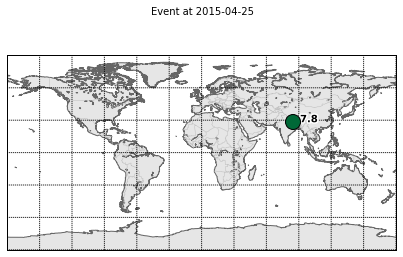

In [144]:
_ = cat.plot()

In [145]:
event = cat[0]

In [135]:
station = client.get_stations(network='CN', station='INK')[0][0]

In [128]:
t = obspy.UTCDateTime('2015-04-25 06:11:25')
st = client.get_waveforms('CN', 'INK', '*', '*', t, t + 1.6*3600)

In [130]:
st.write("nepal.cn.ink.mseed", format="MSEED")

In [166]:
st = obspy.read('nepal.cn.ink.mseed')

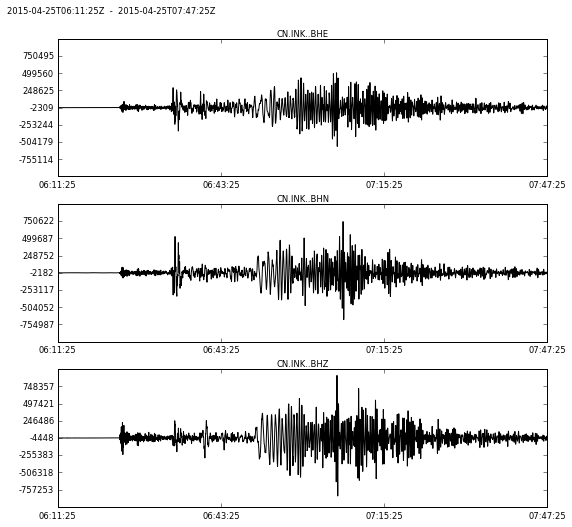

In [167]:
st.plot()

In [ ]:
event.origins[0]

In [153]:
tr = st[0]

In [158]:
print(station.latitude, station.longitude)
print(event.origins[0].latitude, event.origins[0].longitude)

(68.3065, -133.5254)
(28.1473, 84.7079)


In [159]:
baz = 326.26639

In [157]:
_, az, baz = obspy.core.util.geodetics.gps2DistAzimuth(station.latitude, station.longitude, 
                                                       event.origins[0].latitude, event.origins[0].longitude)

ValueError: value 429.182397185 out of bounds (-180, 180)

In [174]:
tr = st[0]

In [175]:
tr.stats

Stats({u'network': u'CN', '_format': 'MSEED', u'mseed': AttribDict({'record_length': 512, 'encoding': u'STEIM2', 'filesize': 1235968, u'dataquality': u'M', 'number_of_records': 2414, 'byteorder': u'>'}), u'sampling_rate': 40.0, u'station': u'INK', u'location': u'', u'starttime': UTCDateTime(2015, 4, 25, 6, 11, 25), u'delta': 0.025, u'calib': 1.0, u'npts': 230401, u'endtime': UTCDateTime(2015, 4, 25, 7, 47, 25), u'channel': u'BHE'})

In [173]:
a = st.copy()
a.rotate(method='NE->RT', back_azimuth=326.26639)

In [172]:
a.

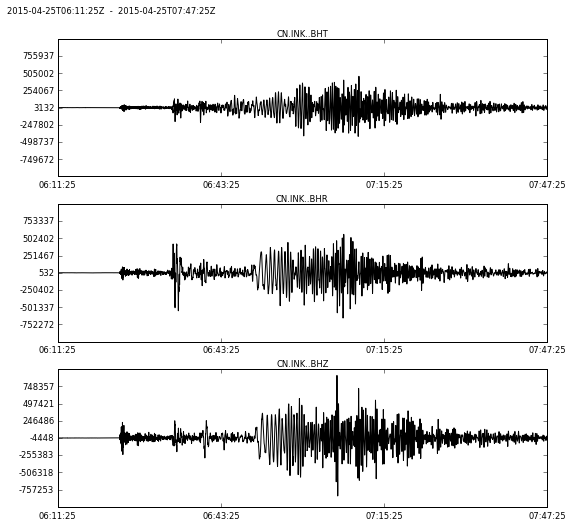

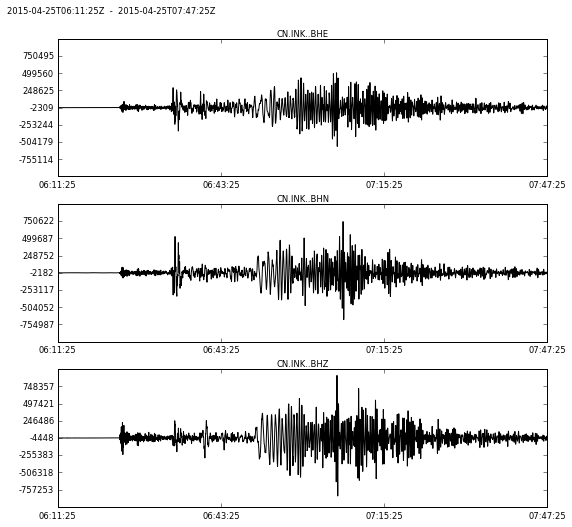

In [171]:
a.plot()
st.plot()

In [116]:
# Terremoto de São Vicente, 23-04-2008
event = client.get_events(starttime=t, endtime=t + 100)[0]

In [118]:
event.resource_id

ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=5111620")

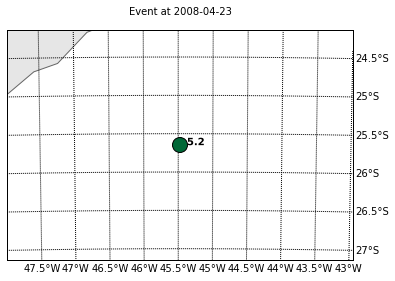

In [80]:
_ = event.plot(projection='local')

In [85]:
station = client.get_stations(network='BL', station='VABB')[0][0]

In [96]:
station.description

In [102]:
vabb = client.get_waveforms('BL', 'BB15B', '*', '?', t0, t0 + 20000)

FDSNException: No data available for request.

## Ondas Love

In [48]:
shape = (200, 700)
spacing = 1000
extent = [0, shape[1]*spacing, shape[0]*spacing, 0]
densidade = np.ones(shape)*2700
velocidade = np.ones(shape)*3800
l1 = 40e3//spacing
densidade[l1:,:] = 3300
velocidade[l1:,:] = 5000

Agora vamos criar o nosso simulador de ondas.

In [38]:
sim1 = ElasticSH(velocidade, densidade, spacing=spacing, taper=0.005)

e colocar uma fonte explosiva na superfície.

In [45]:
f = 0.05
sim1.add_point_source((20e3//spacing, 50e3//spacing), Ricker(5, f, 1/f))

Agora que temos nossa simulação pronta, rode a célcula abaixo para avançar a simulação 400 passos no tempo.

In [46]:
sim1.run(400)

|##################################################|100% Ran 400 iterations in 8.58055 seconds.

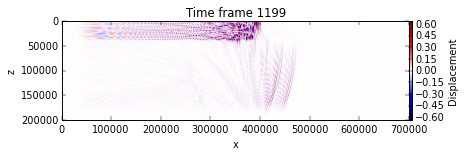

<function fatiando.seismic.wavefd.plot>

In [47]:
sim1.explore(every=20)

In [10]:
sim1.animate(every=20, embed=True, dpi=50, cutoff=0.5)